## Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of an image classifier, from loading and inspecting the dataset to implementing and training a Convolutional Neural Network architecture. The sections guide you but you do not have to follow that specific order.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you using Colab notebook, save it as .ipynb and upload it. If you have your own machine with Jupyter installed, you can work there as well. Upload only the .ipynb file.

## Rules and Comments
- From the list of datasets and architectures listed in Canvas, each student was assigned **1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description.
- This is a DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course).
- **Deadline is October 17th 11:59 PM** (For late submission it is October 23rd 11:59PM)
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

##### Name: Sándor Balázs
##### Neptun ID: AZA6NL
##### Network: ResNet18
##### Objects: Fruits 360

## Task description
Your task is to compare the performance of a given pre-trained model and a modified version of it, using a given dataset. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem.

Steps
1. If your dataset has more than 5 classes, then select 5 classes of your choice (explain why). If your dataset has 5 or less classes, ignore this step.
2. The dataset should be split into train, validation and test sets. Some datasets already have these splits, otherwise, you can split the training set into validation and test sets.
3. Use the test set to do inference with the pre-trained model. Calculate the accuracy of the pre-trained model.
4. Modify the pre-trained model and train it with the train/validation sets. Modifying means removing/replacing/adding layers. We recommend changing the: head (you need to do this because the pre-trained models were created to predict 1000 classes from Imagenet, however, in your case, the number of classes is different, so you must change the head); backbone (remove/replace layers in the backbone. Be aware that once you do that, you need to be able to adjust the networks output dimensions by changing the properties like filter size, padding, etc)
5. Use the test set to do inference with the newly modified/trained model. Calculate the accuracy.
6. Compare the results from the pre-trained model and the modified version.
7. Explain the differences.
Please submit only the notebook to Canvas. (Do not upload the dataset nor the models)

There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualizations (matplotlib, seaborn, ...) of the accuracy, loss, and confusion matrix. Use Early stopping and save the best model while training your network.
### In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.
There are some example questions at the end of the notebook.

## -1. Runtime environment
I ran the project on my own computer in my own environment built using python venv using CUDA.

In [1]:
# python -m venv venv
# venv\Scripts\activate
# pip install numpy
# pip install torch==2.1.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html
# pip install torchvision
# pip install torchsummary
# pip install pandas
# pip install jupyter
# pip install graphviz
# pip install matplotlib
# pip install IPython
# pip install sklearn
# pip install seaborn
# pip install pretty_confusion_matrix

# jupyter notebook

In [1]:
!nvidia-smi

Mon Oct 23 18:20:48 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.84                 Driver Version: 545.84       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   37C    P8               1W /  50W |    280MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler # customize the training
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings
warnings.filterwarnings("ignore") 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

### The dataset's structure.
My dataset was the Fruits 360 dataset with images from fruits and vegetables. There was 131 classes. I chose 2x5 classes from these. I deleted all the remains datas. The fruits360 folder contains a train, val, test folders for the cases.

The selected classes: 

    Apples only: fruits360_apples -> braeburn, crimson, golden, granny, pink_lady 
    
    Mixed fruits, veggys: fruits360_mix -> apple, carrot, cucumber, pear, zucchini
    

#### Check the number of images and class balances in the  train, validation and test set

#### Splitting the dataset

The datasets ar pre splitted:

Apples only:

    The part sizes: fruits360_apples -> train: 1579, val: 789, test: 789
    
Mixed fruits:

    The part sizes: fruits360_mix -> train: 996, val: 497, test: 496

### Batch_size
I have a 4GB GPU, for this size the 64 batch seemed size is ideal for two modells and a correct running time.

#### Pre-processing the dataset (data loader with transformations)

In [8]:
Batch_size=64;

#Size 224 is ideal for ResNet18
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomAffine(degrees=(5, 50), translate=(0.1, 0.3), scale=(0.9, 1.1)),
        transforms.RandomPerspective(distortion_scale=0.2),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'fruits360_apples'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=Batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
print("Readed classes: ")
print(class_names)
print("Readed dataset sizes: ")
print(dataset_sizes)

Readed classes: 
['braeburn', 'crimson', 'golden', 'granny', 'pink_lady']
Readed dataset sizes: 
{'train': 1579, 'val': 789, 'test': 789}


#### Loading one example for each object type from the dataset
Show some images and labels of your dataset

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

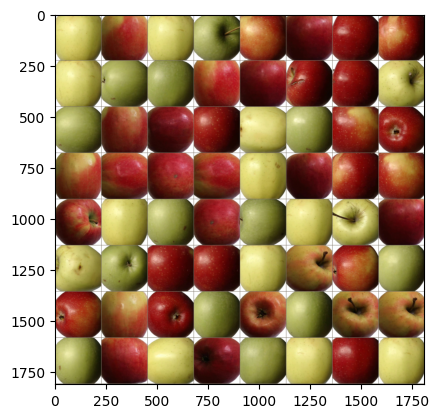

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## 2. Convolutional Neural Network Architecture
Load the pre-trained CNN architecture you were given. Reduce the size of the given model by removing some layers and parameters with less influence. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

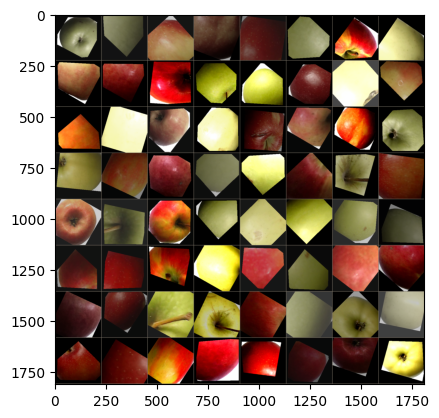

In [13]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

#### Load the given pre-trained model

In [9]:
model = models.resnet18()

#### Summary of the given pre-trained model

ResNet18 Architecture

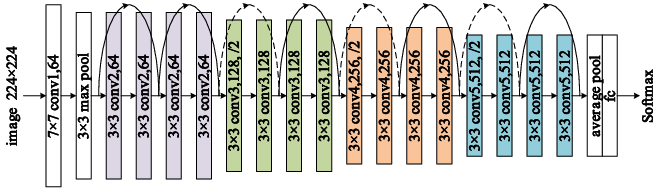

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Create the model trainer method.

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_acc_h=[]
    train_acc_h=[]
    for epoch in range(num_epochs):
      
            
        print('Epoch {}/{} LR {:.6f}'.format(epoch, num_epochs - 1, scheduler.get_last_lr()[0]))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
                train_acc_h.append(epoch_acc)
            # deep copy the model
            if phase == 'val':
                val_acc_h.append(epoch_acc)
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                

        print('Test started')
    phase == 'test'
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        test_loss = running_loss / dataset_sizes[phase]
        test_acc = running_corrects.double() / dataset_sizes[phase]
        
    time_elapsed = time.time() - since
    print('Training and testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Test Acc: {:4f}'.format(test_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_h, train_acc_h, test_acc

### Build the basic model.

In [12]:
model = models.resnet18()
numrs = model.fc.in_features
# Here the size of the output is 2.
model.fc = nn.Linear(numrs, len(class_names))

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [14]:
### Run the training

In [13]:
model, val_acc_h, train_acc_h, test_acc = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9 LR 0.000100
----------
train Loss: 0.6563 Acc: 0.7400
val Loss: 0.4192 Acc: 0.8028
Test started
Epoch 1/9 LR 0.000100
----------
train Loss: 0.3616 Acc: 0.8735
val Loss: 0.0468 Acc: 0.9738
Test started
Epoch 2/9 LR 0.000100
----------
train Loss: 0.2495 Acc: 0.9096
val Loss: 0.2274 Acc: 0.9175
Test started
Epoch 3/9 LR 0.000100
----------
train Loss: 0.2327 Acc: 0.9116
val Loss: 0.1327 Acc: 0.9336
Test started
Epoch 4/9 LR 0.000100
----------
train Loss: 0.2497 Acc: 0.9106
val Loss: 0.0375 Acc: 1.0000
Test started
Epoch 5/9 LR 0.000100
----------
train Loss: 0.2391 Acc: 0.9287
val Loss: 0.0654 Acc: 0.9899
Test started
Epoch 6/9 LR 0.000100
----------
train Loss: 0.2495 Acc: 0.9056
val Loss: 0.0063 Acc: 1.0000
Test started
Epoch 7/9 LR 0.000010
----------
train Loss: 0.1918 Acc: 0.9367
val Loss: 0.0073 Acc: 1.0000
Test started
Epoch 8/9 LR 0.000010
----------
train Loss: 0.1329 Acc: 0.9618
val Loss: 0.0051 Acc: 1.0000
Test started
Epoch 9/9 LR 0.000010
----------
train Loss: 0

## Plot the training

In [14]:
def plot_acc(train_acc_h,val_acc_h, test_acc): 
    plt.figure(figsize=(10,6))
    plt.xlabel('Iteration')
    plt.ylabel('Acc')
    plt.title('Acc by Iteration')
    plt.plot(torch.tensor(train_acc_h, device = 'cpu')*100)
    plt.plot(torch.tensor(val_acc_h, device = 'cpu')*100)
    plt.plot(torch.tensor(test_acc, device = 'cpu')*100*np.ones(len(val_acc_h)))
    plt.ylim((50,100))
    plt.legend(['train', 'valid', 'test'])

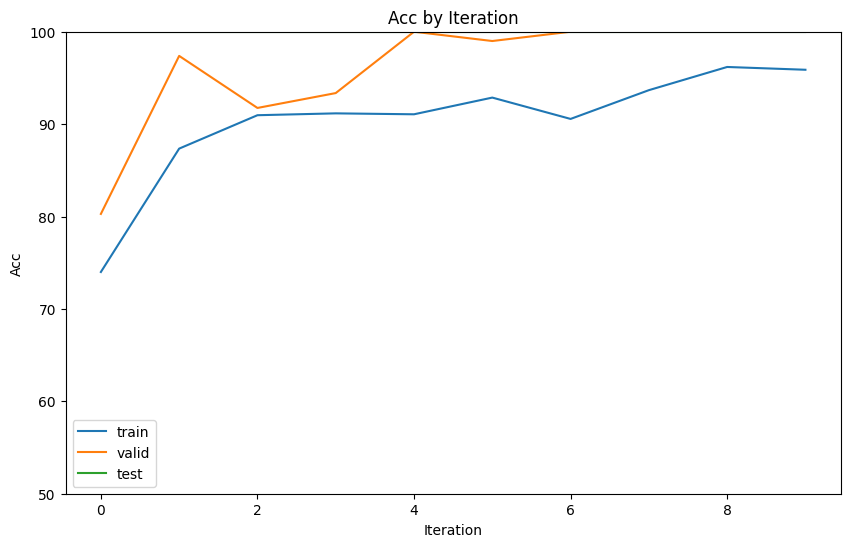

In [15]:
plot_acc(train_acc_h,val_acc_h, test_acc)

### Visualize the resoults

In [16]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                fig = plt.figure(figsize=(10,10))
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

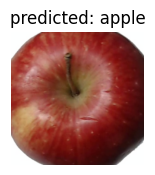

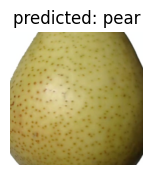

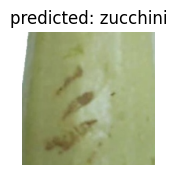

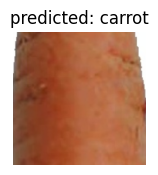

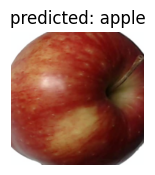

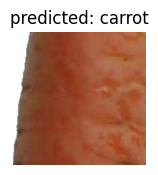

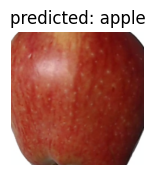

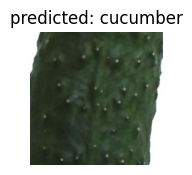

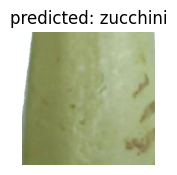

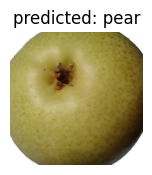

In [17]:
visualize_model(model)

#### Implement the new architecture with less parameter

In [18]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss() # BinaryCrossEntropyLoss

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [19]:
model_ft, val_acc_h, train_acc_h, test_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9 LR 0.001000
----------


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
visualize_model(model_ft)

In [ ]:
plot_acc(train_acc_h,val_acc_h, test_acc)


#### Summary of the new architecture

In [ ]:
# ADD YOUR CODE HERE

## 3. Training

#### Define your loss function

In [ ]:
# ADD YOUR CODE HERE

#### Define your optimizer

In [ ]:
# ADD YOUR CODE HERE

#### Train your network

In [ ]:
# ADD YOUR CODE HERE

#### Show the loss on training and validation sets

In [ ]:
# ADD YOUR CODE HERE

#### Show the accuracy on training and validation sets

In [ ]:
# ADD YOUR CODE HERE

#### Save your trained CNN

In [ ]:
# ADD YOUR CODE HERE

## 4. Evaluation and Testing
Load your trained CNN and evaluate it on the test set.
Show the confusion matrix on the test set.
Show some predictions on the test set (3 is enough) by plotting the image and printing the prediction and ground truth.
Show some missed predictions (3 is enough) and try to explain why it was difficult for the model to recognize these images.

#### Evaluate your model

In [ ]:
# ADD YOUR CODE HERE

#### Show the test accuracy next to the training and validation

In [ ]:
# ADD YOUR CODE HERE

#### Confusion matrix

In [ ]:
# ADD YOUR CODE HERE

#### Show some predictions

In [ ]:
# ADD YOUR CODE HERE

#### Missed predictions

In [ ]:
# ADD YOUR CODE HERE

## 5. Some example questions that help you prepare for the defense

* Data
    - Describe your dataset.
    - List augmentation techniques.
    - Normalization standardization why do we use them?

* Model
    - Describe the model and its parameters (Convolutional Layer, Pooling
    - Layer, flatten, concatenation, activation, linear, argmax().
    - How can we change the output dimension? What happens if we change the head or the backbone? (filter number or replace them,...).

* optimizer
    - Describe the optimizer. What parameters does it have? (some connection to the date, model, and loss function)

* Loss function and regularisation
    - Describe the loss functions and some regularization methods.

* Results
    - Describe the results based on overfitting, underfitting, bias, and variance.
    - Does the trained model complete the given task? What is the baseline for classification?
    - Then the data balance, if it were unbalanced how would they deal with it?
    - What other aspects can cause biased output? What simple methods do we have to unbias the model?
    - Try to explain why it was difficult for the model to recognize the missed predictions.
    - How can we improve the model?

#### Answer the questions (optional, but recommended for the  preparation)

In [ ]:
# ADD YOUR ANSWERS HERE